In [1]:
from qm.QuantumMachinesManager import QuantumMachinesManager
from qm.octave import *
from qm.qua import *


#General os library 
import os
import time as time_package
import sys


import matplotlib.pyplot as plt
from qualang_tools.units import unit
from set_octave import get_L0_and_IF
from configuration_multiple_jumps import *
from qm import SimulationConfig, LoopbackInterface
from qualang_tools.units import unit
from qualang_tools.loops import from_array
u = unit()
from qualang_tools.plot import interrupt_on_close
from qualang_tools.results import progress_counter, fetching_tool
from qualang_tools.addons.variables import assign_variables_to_element


sys.path.append(r'C:\Users\HQClabo\Documents\Code\QuantumMachine\Guillaume\NonLinearRes_calib_30_03_2023\Analysis_Function\NonLinearRes')
import AnFunc as an # analysis function
import imageio
import scipy.io
from scipy import signal

# OPX configuration 

In [2]:
#Octave & OPX configuration 

opx_ip = '128.178.175.167'
opx_port = 80
octave_ip = '128.178.175.167'
octave_port = 52


octave_config = QmOctaveConfig()
octave_config.set_calibration_db(os.getcwd()) #Path to the calibration database 

octave_config.add_device_info('octave1', octave_ip, octave_port) #Add a device refered to as octave 1
octave_config.set_opx_octave_mapping([('con1', 'octave1')])  # set default mapping between analog outputs of OPX and the octave

qmm = QuantumMachinesManager(host=opx_ip, port=opx_port, octave=octave_config)
qm = qmm.open_qm(config)


#Mixers for the fluxline 
qmm.octave_manager.set_clock("octave1", ClockType.External, ClockFrequency.MHZ_10) # External clock on the octave 
qm.octave.set_lo_source("fluxline", OctaveLOSource.Internal) # Use internal LO for the fluxline 
qm.octave.set_lo_frequency("fluxline", LO_fluxline)  # Set the frequency of the LO 
qm.octave.set_rf_output_gain("fluxline", -10)  # can set gain from -10dB to 20dB
qm.octave.set_rf_output_mode("fluxline", RFOutputMode.on)  # The LO output is always on (could change to a trigger)

#Mixers for the resonator 
qm.octave.set_qua_element_octave_rf_in_port("resonator", "octave1", 1) #input port 1 is set for the resonator 
qm.octave.set_downconversion("resonator", lo_source=RFInputLOSource.Internal)  # The LO for the demodulation is the interal LO  
qm.octave.set_lo_frequency("resonator", LO_readout)  # assign the LO inside the octave to element

2023-04-07 20:58:24,040 - qm - INFO - Performing health check
2023-04-07 20:58:24,053 - qm - WARNING -   HC Warning: Potential hardware issue with QSync in controller con1, multiple controllers sync cannot be guaranteed, please inform QM
2023-04-07 20:58:24,054 - qm - INFO - Health check passed


In [3]:
def update_two_photon_lenght(twoPhoton_len,config,qmm):
    """ Update the length of the fluxline pulse in the configuration file"""

    config["pulses"]["twoPhoton"]["length"]=twoPhoton_len


    #Update the config with the modified values above 
    qm = qmm.open_qm(config)
    
    return config, qm


def update_readout_lenght(Readout_Len,config,qmm):
    """ Macro to update the readout length in the configuration file"""
    
    config["pulses"]["zero_pulse"]["length"]=Readout_Len
    config["integration_weights"]["cosine_weights"]["cosine"][0]=(1.0, Readout_Len)
    config["integration_weights"]["cosine_weights"]["sine"][0]=(0.0, Readout_Len)
    config["integration_weights"]["sine_weights"]["cosine"][0]=(0.0, Readout_Len)
    config["integration_weights"]["sine_weights"]["sine"][0]=(1.0, Readout_Len)
    config["integration_weights"]["minus_sine_weights"]["cosine"][0]=(0.0, Readout_Len)
    config["integration_weights"]["minus_sine_weights"]["sine"][0]=(-1.0, Readout_Len)


    #Update the config with the modified values above 
    qm = qmm.open_qm(config)
    
    return config, qm


def update_pulse_amplitude(pulse_amp,config,qmm):
    config["waveforms"]["const_wf"]['sample']=pulse_amp
    
    #Update the config with the modified values above 
    qm = qmm.open_qm(config)
    
    return config, qm

def update_offset(offset_1, offset_2,config,qmm):
    """ Update the input offsets of the qm in the configuration file """
    
    config['controllers']["con1"]["analog_inputs"][1]['offset']=offset_1
    config['controllers']["con1"]["analog_inputs"][2]['offset']=offset_2
    
    
    qm=qmm.open_qm(config)
    
    return config, qm

In [ ]:
#Defines the functions 

#Function for a single IQ trace 
def single_IQ_trace(IF_pump,IF_resonator,Offset_IF,amp_factor,n_runs,Readout_Delay,Readout_Len,qm):
    
    """ gets the IQ values for a given pump frequency and amplitude 
    IF_Pump : If frequency of the pump 
    IF_resonator : IF frequency of the resonator (should be calculated before such that it gives half of the pump total frequency (LO_fluxline+IF_pump)/2-LO_readout
    Offset_IF : in case the down converted frequency is not perfectly centered around 0. This is typically kept to zero
    amp_facot amplitude factor of the pump
    n_runs : number of points 
    Readout_delay : waiting time before the first readout in clock cycle
    Readout_Len : time in ns of each readout 
    qm : quantum manager 
    
    returns :
    
    I: vector n_runs components of the frist quadrature
    Q : vector of n_runs compontents of the second quadrature
    time : vector of the time """
    

    with program() as IQ_blobs:

        n = declare(int)
        i = declare(int)
        I = declare(fixed)
        Q = declare(fixed)
        assign_variables_to_element("resonator", I,Q) #This line forces the OPX to assign I and Q to the resonator element such that the loops can happen in parallel as intented
        I_st = declare_stream()
        Q_st = declare_stream()
        f = declare(int)

        # Change the of the pump and resonator to demodulate better
        update_frequency("resonator",IF_resonator+Offset_IF) 
        update_frequency("fluxline",IF_pump)

        #Play a continuous loop sending a pulse through the fluxline 
         # Starts playing on the fluxline 
        # with infinite_loop_():
        #     play("pumping"*amp(amp_factor), 'fluxline') #Play the pulse on the fluxline  

        with for_(i, 0, i < np.round((n_runs*(Readout_Len+300)+Readout_Delay*4)/twoPhoton_len)+1, i + 1): # the 300 is added because there is a time delay associated to saving the data in the steam. The *4 is necessary because the waiting time is in clockcycle 
            play("pumping" * amp(amp_factor), 'fluxline')  # Play the pulse on the fluxline


        #Delay time before the first readout 
        wait(Readout_Delay,"resonator")

        with for_(n, 0, n < n_runs, n + 1):

            #Demodulate for the length 
            measure(
                "fake_readout",
                "resonator",
                None,
                dual_demod.full("cos", "out1", "sin", "out2", I),
                dual_demod.full("minus_sin", "out1", "cos", "out2", Q),
            )

            save(I, I_st)
            save(Q, Q_st)


        with stream_processing():
            I_st.with_timestamps().save_all("I")
            Q_st.with_timestamps().save_all("Q")
        
    job = qm.execute(IQ_blobs)
    results = fetching_tool(job, data_list=["I", "Q"], mode="live")
    
    fig = plt.figure()
    interrupt_on_close(fig, job)
    while results.is_processing():
       
        I, Q = results.fetch_all()
        
        dt=(I["timestamp"][1]-I["timestamp"][0])*1e-9 #time between sucessive points
        I = u.demod2volts(I["value"], Readout_Len) #diviser par la duree du pulse 
        Q = u.demod2volts(Q["value"], Readout_Len)

        #plt.subplot(211)
        plt.title("IQ blobs")
        plt.subplot(211)
        plt.cla()
        plt.plot(I[:min(len(I), len(Q))], Q[:min(len(I), len(Q))], ".", markersize=2)
        plt.xlabel("I")
        plt.ylabel("Q")
        plt.axis("equal")
        plt.subplot(212)
        plt.cla()
        tau=np.linspace(1,min(len(I), len(Q)),min(len(I), len(Q)))
        plt.plot(tau,np.angle(I[:min(len(I), len(Q))]+1j*Q[:min(len(I), len(Q))]), ".", markersize=2)
        plt.xlabel("nb_points")
        plt.ylabel("phase")
        plt.pause(0.1)
       
    I, Q = results.fetch_all()
    dt=(I["timestamp"][1]-I["timestamp"][0])*1e-9 #time between sucessive points
    I = u.demod2volts(I["value"], Readout_Len) #diviser par la duree du pulse 
    Q = u.demod2volts(Q["value"], Readout_Len)
    time=np.linspace(1,len(I), len(I),len(I))*dt # time in micro seconds
    
    return I,Q,time 


def Update_single_IQ_trace(config,IF_pump,IF_resonator,Offset_IF,amp_factor,qm,nb_desired_jumps,nb_points_between_jumps,nb_angle=100,n_avg=10,init_Readout_Len=50_000,init_nruns=100000,threshold=1e-5 ):
    
    #Initialisation
    counter=0
    jumps=[] 
    stop=False
    vaccum=False
    
    Readout_Len= init_Readout_Len    # Sets the readout to the initial wanted value 
    config,qm=update_readout_lenght(Readout_Len,config,qmm)
    
    
    n_runs=init_nruns # set the number_runsto the initial wanted number of runs 
    
    #First estimate of the total time 
    Total_time=n_runs*Readout_Len*1e-9

    counter+=1
    
    print("########### Iteration number : {} ##########".format(counter))
    print("The program is initalized with :")
    print("A readout length of {}".format(Readout_Len))
    print("The Number of points  {}".format(n_runs))   
    print("Time for iteration  {} min".format(Total_time/60)) 


    # Begins the loop that is stopped under the following conditions : we have more then 90 % of the number of desired jumps but less than twice (otherwise, we might not have the optimal readout length)
    # stop is set to true 
    
    while stop==False:


        #Run the program for a single IQ trace once 
        time_package.sleep(1)
        I,Q,time=single_IQ_trace(IF_pump,IF_resonator,Offset_IF,amp_factor,n_runs,Readout_Delay,Readout_Len,qm)
        
        print("Out_of_qm")
        plt.close()

        #rotate data and average 
        I_2d=np.reshape(I, (1, I.shape[0])) 
        Q_2d=np.reshape(Q, (1, Q.shape[0]))
        rot_I,rot_Q=an.rotate_data(I_2d,Q_2d,nb_angle)
        average_I,average_Q,time_average=an.average_data(rot_I,rot_Q,time,n_avg)
        av = np.mean(abs(average_I))
        print(av)
        
        # We look if the average value is above our threshold. Being blow this threshold tells use that we should measure with the minimum readout len anyway so we can stop 
        if av>threshold:
            
            #renormalize the data and find jumps 
            length_array=average_I.shape[1] 
            jumps=an.find_jumps(average_I[0]/av,length_array,Nw=10)
            print("Jumps found {}".format(len(jumps)))
            
            #Check if we have succed. If yes, the program is stoped
            if nb_desired_jumps*0.9<len(jumps)<2*nb_desired_jumps:
                stop=True 
                print("Success")
            # if not, we start a new iteration
            else:
                counter+=1
                print("########### Iteration number : {} ##########".format(counter))
        
        #If we are below threshold, we stop 
        else: 
            vaccum=True
            print("vaccum state")
            stop=True 
            

        # If the program is not stopped, we continue 
        if stop==False: 
            
            #If we have found zero jump, we increase the parameters  
            if (len(jumps)==0):
                
                print("no jumps found found")

                #If the length was already between 1.5 and 2 ms
                if 1_500_000<Readout_Len<=2_000_000:

                    print("We update the number of runs")
                    Readout_Len=2_000_000 #we set the readout_len
                    config,qm=update_readout_lenght(Readout_Len, config,qmm)
                    n_runs=2*n_runs #double the number of runs

                else:

                    print("We update the readout length")
                    Readout_Len=2*Readout_Len 
                    config,qm=update_readout_lenght(Readout_Len, config,qmm)

                    #If the readout_len is larger than 2 ms, we set 2 ms  
                    if Readout_Len>2_000_000:
                        Readout_Len=2_000_000

                Total_time=n_runs*Readout_Len*1e-9
                print("New readout length of {}".format(Readout_Len))
                print("New number of points  {}".format(n_runs))   
                print("Time for iteration  {} min".format(Total_time/60)) 

                if Total_time>10*60: #If the total time is larger than 10 minutes 
                    stop=True 

            # In the case we find some jumps 
            else:

                time_per_jump=time_average[length_array-1]/len(jumps) #average time per jump 
                Total_time= time_per_jump*nb_desired_jumps #total time I should measure to get the number of desired jumps 

                Readout_Len=4*round(round(time_per_jump*1e9/nb_points_between_jumps)/4) # expected readout length given that I would like x number of points between jumps 

                if Readout_Len>2_000_000:
                    Readout_Len=2_000_000

                if Readout_Len<50_000:
                    Readout_Len=50_000

                n_runs=round(Total_time*1e9/Readout_Len)

                #Update the readout length based on the single test  
                config,qm=update_readout_lenght(Readout_Len, config,qmm)

                print("New readout length of {}".format(Readout_Len))
                print("New number of points {}".format(n_runs))
                print("Time for iteration  {} min".format(Total_time/60))

                if Total_time>10*60: #If the total propsed time is larger than 10 minutes 
                    stop=True 
            
    
    return I,Q,rot_I,rot_Q,time,counter,Readout_Len,n_runs,jumps,vaccum

# Testing the pump

In [4]:
#Calibration of the fluxline mixer 
qm.octave.calibrate_element("fluxline", [get_L0_and_IF(config, "fluxline")])  
qm = qmm.open_qm(config)

2023-04-07 14:25:07,173 - qm - INFO - Flags: 
2023-04-07 14:25:07,174 - qm - INFO - Compiling program
2023-04-07 14:25:09,791 - qm - INFO - Sending pre-compiled program to QOP


In [15]:
# Applies an infinite loop pump for testing 

amp_factor=0.1

pulse_amp=0.125/2
config,qm=update_pulse_amplitude(pulse_amp,config,qmm) 

twoPhoton_len=1000
config,qm=update_two_photon_lenght(twoPhoton_len,config,qmm)

with program() as TwoPhoton:
    with infinite_loop_():
        play("pumping"*amp(amp_factor), 'fluxline')
           
job = qm.execute(TwoPhoton)


2023-02-16 16:39:23,541 - qm - INFO - Flags: 
2023-02-16 16:39:23,541 - qm - INFO - Sending program to QOP
2023-02-16 16:39:23,568 - qm - INFO - Executing program


In [19]:
#Two stop the two photon pumping 
job.halt()

True

# Checking the ADC 
This allows checking that the ADC is not saturated to set a proper gain, correct for DC offsets and define the time of flight.

For this, we send a Twophoton pulse and look at the the raw adc 

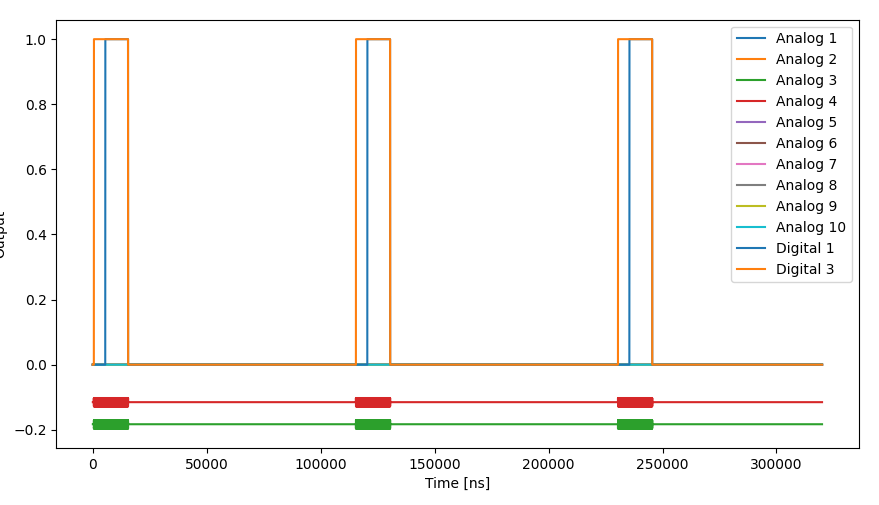


In [4]:
gain=-6
config['controllers']['con1']['analog_inputs'][1]["gain_db"]=gain
config['controllers']['con1']['analog_inputs'][2]["gain_db"]=gain
qm = qmm.open_qm(config)

In [40]:
%matplotlib qt

#Sets the pulse length and the pulse amplitude at the resonator 
pulse_len=100_000
config,qm=update_readout_lenght(pulse_len,config,qmm)

pulse_amp=0.125/2
config,qm=update_pulse_amplitude(pulse_amp,config,qmm) 

twoPhoton_len=100_000
config,qm=update_two_photon_lenght(twoPhoton_len,config,qmm)

Readout_Delay = 5000 //4 # Delay before the first readout in ns (convert from clockcycle)

IF_pump=0.19728e9 # defines the IF of the pump 

amp_factor=0.4 #Amplitude factor of the pump 

n_avg = 100  # Number of averaging loops

cooldown_time = 100_000 // 4 #cooldown time between the averages

offset_1=0
offset_2=0
config,qm=update_offset(offset_1, offset_2,config,qmm)


with program() as raw_trace_prog:
    
    n = declare(int)
    adc_st = declare_stream(adc_trace=True)
    
    update_frequency("fluxline",IF_pump)

    with for_(n, 0, n < n_avg, n + 1):
        
        play("pumping"*amp(amp_factor), 'fluxline')
        
        #Delay time before the first readout 
        wait(Readout_Delay,"resonator")
        measure("fake_readout", "resonator", adc_st)
        
        wait(cooldown_time, "resonator") #Maybe need to cooldown both resonator and fluxline

    with stream_processing():
        
        # Will save average:
        adc_st.input1().average().save("adc1")
        adc_st.input2().average().save("adc2")
        
        # Will save only last run:
        adc_st.input1().save("adc1_single_run")
        adc_st.input2().save("adc2_single_run")

        
simulation = False
if simulation:
    
    simulation_config = SimulationConfig(
        duration=80000, simulation_interface=LoopbackInterface([("con1", 3, "con1", 1)])
    )
    job = qmm.simulate(config, raw_trace_prog, simulation_config)
    job.get_simulated_samples().con1.plot()
    
else: 
    #Execute the program     
    qm = qmm.open_qm(config)
    job = qm.execute(raw_trace_prog)

    results = fetching_tool(job, data_list=["adc1", "adc2", "adc1_single_run","adc2_single_run"], mode="wait_for_all")

    adc1, adc2, adc1_single_run, adc2_single_run = results.fetch_all()

    adc1 = u.raw2volts(adc1)
    adc2 = u.raw2volts(adc2)
    adc1_single_run = u.raw2volts(adc1_single_run)
    adc2_single_run = u.raw2volts(adc2_single_run)

    #Plotting 
    plt.figure()
    plt.subplot(121)
    plt.title("Single run")
    plt.plot(adc1_single_run, label="Input 1")
    plt.plot(adc2_single_run, label="Input 2")
    plt.xlabel("Time [ns]")
    plt.ylabel("Signal amplitude [V]")
    plt.legend()

    plt.subplot(122)
    plt.title("Averaged run")
    plt.plot(adc1, label="Input 1")
    plt.plot(adc2, label="Input 2")
    plt.xlabel("Time [ns]")
    plt.legend()
    plt.tight_layout()

    print("The mean offset of port 1 is: {}".format(np.mean(adc1)))
    print("The mean offset of port 2 is: {}".format(np.mean(adc2)))

2023-04-07 13:38:32,468 - qm - INFO - Flags: 
2023-04-07 13:38:32,469 - qm - INFO - Sending program to QOP
2023-04-07 13:38:32,907 - qm - INFO - Executing program
The mean offset of port 1 is: -0.01378283203125
The mean offset of port 2 is: -0.006668743383789063


# Spectrum Analyzer

Program that plots the amplitude of the two quadrature as a function of the readout frequency 

To observe a sharp peak around the correct frequency, the readout len should be long enough to resolve frequencies. For i.e 2_000_000

In [5]:
%matplotlib qt

amp_factor=0.25 #amplitude factor for for the pump 

#length of the readout 
Readout_Len=2_000_000
config,qm=update_readout_lenght(Readout_Len,config,qmm)


#number of average 
n_runs = 1000

cooldown_time = 16000 // 4 # Waiting time before playing the new pulse 

#The IF frequency is defined as half of the pump frequency 
IF_pump=0.1972e9  # defines the IF of the pump 
IF_readout=(LO_fluxline+IF_fluxline)/2-LO_readout

# Frequency sweep in Hz
span=10 * u.kHz
df = 100 * u.Hz
freqs = np.arange(IF_readout-span, IF_readout+span, df) 


i_runs = n_runs * len(freqs)


with program() as IQ_blobs:
    
    n = declare(int)
    i = declare(int)
    I = declare(fixed)
    Q = declare(fixed)
    I_st = declare_stream()
    Q_st = declare_stream()
    f = declare(int)

    #updates the IF pump 
    update_frequency("fluxline",IF_pump)
    
    # Starts playing on the fluxline
    with infinite_loop_():
        play("pumping"*amp(amp_factor), 'fluxline') #Play the pulse on the fluxline  
    
    with for_(n, 0, n < n_runs, n + 1):
        
        #Sweep the domudlation frequency 
        with for_(*from_array(f,freqs)):
            
            update_frequency("resonator",f) #change the demodulation frequency 
            reset_phase("resonator")
            
            #Measure at the output 
            measure(
                "fake_readout",
                "resonator",
                None,
                dual_demod.full("cos", "out1", "sin", "out2", I),
                dual_demod.full("minus_sin", "out1", "cos", "out2", Q),
            )

            save(I, I_st)
            save(Q, Q_st)
            wait(cooldown_time, "resonator")

    with stream_processing():
        I_st.buffer(len(freqs)).average().save("I") #Continously average the different buffers of size len(freqs)
        Q_st.buffer(len(freqs)).average().save("Q")

        
simulation = False
if simulation:
    simulation_config = SimulationConfig(
        duration=80000, simulation_interface=LoopbackInterface([("con1", 3, "con1", 1)])
    )
    job = qmm.simulate(config, IQ_blobs, simulation_config)
    job.get_simulated_samples().con1.plot()
    
else:
  

    job = qm.execute(IQ_blobs)
    results = fetching_tool(job, data_list=["I", "Q"], mode="live")
    # Live plotting
    fig = plt.figure()
    interrupt_on_close(fig, job)  #  Interrupts the job when closing the figure
    
    while results.is_processing():
        I, Q = results.fetch_all()
        I = u.demod2volts(I, Readout_Len)
        Q = u.demod2volts(Q, Readout_Len)

        #plt.subplot(211)
        
        plt.title("IQ blobs")
        plt.subplot(211)
        plt.cla()
        plt.plot(freqs-IF_readout, np.sqrt(Q**2+I**2), "-", markersize=2) #Plot the power vs IF frequency readout 
        plt.xlabel("freqs")
        plt.ylabel("Power")
        plt.subplot(212)
        plt.cla()
        plt.plot(freqs-IF_readout, signal.detrend(np.unwrap(np.angle(I+1j*Q))), "-", markersize=2) #plot the phase 
        plt.pause(0.1)

2023-04-07 17:51:36,819 - qm - INFO - Flags: 
2023-04-07 17:51:36,820 - qm - INFO - Sending program to QOP
2023-04-07 17:51:53,726 - qm - INFO - Executing program
Execution stopped by user!


# Single frequency IQ blob

Runs the IQ blob program for a single pump frequency that can be dfined with IF pump. The demodulation frequency is automatically taken as half of the total pump frequency

Need to make sure that the new updated IF frequency doesn't go over 350 MHz. 

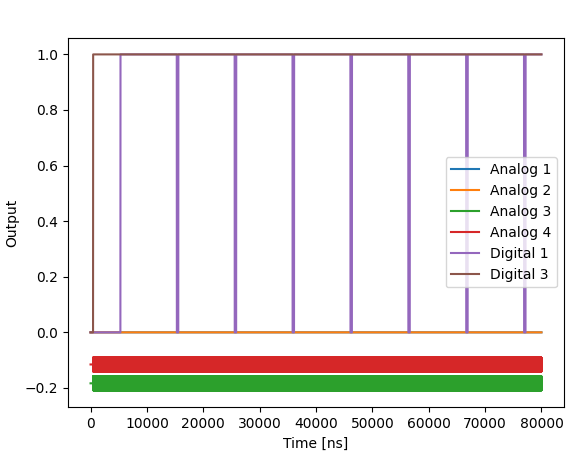

In [167]:
#Starting parameters for the IQ blob program 

#Update the readout pulse 
Readout_Len= 50_000     #6_557_763 #length of the readout pulse in ns 
config,qm=update_readout_lenght(Readout_Len,config,qmm)

#Pump length 
twoPhoton_len=Readout_Len
config,qm=update_two_photon_lenght(twoPhoton_len,config,qmm)

n_runs = 100_000 #Number of readout to do 


#Update the pump IF frequency 
IF_pump= freqs[2] #0.19725e9# defines the IF of the pump 
IF_resonator=(LO_fluxline+IF_pump)/2-LO_readout #demodulate at half of the pump IF by default 


Readout_Delay = 5000 //4 # Delay before the first readout in ns (convert from clockcycle)
amp_factor=0.2 #Prefactor of the amplitude 
Offset_IF=0  #-5670.0 +400 #+1000 #+10000

In [11]:
%matplotlib qt

with program() as IQ_blobs:
    
    n = declare(int)
    i = declare(int)
    I = declare(fixed)
    Q = declare(fixed)
    assign_variables_to_element("resonator", I,Q) #This line forces the OPX to assign I and Q to the resonator element such that the loops can happen in parallel as intented
    I_st = declare_stream()
    Q_st = declare_stream()
    f = declare(int)

    # Change the of the pump and resonator to demodulate better
    update_frequency("resonator",IF_resonator+Offset_IF) 
    update_frequency("fluxline",IF_pump)
    
    #Play a continuous loop sending a pulse through the fluxline 
     # Starts playing on the fluxline 
    # with infinite_loop_():
    #     play("pumping"*amp(amp_factor), 'fluxline') #Play the pulse on the fluxline  
    
    with for_(i, 0, i < np.round((n_runs*(Readout_Len+300)+Readout_Delay*4)/twoPhoton_len)+1, i + 1): # the 300 is added because there is a time delay associated to saving the data in the steam. The *4 is necessary because the waiting time is in clockcycle 
        play("pumping" * amp(amp_factor), 'fluxline')  # Play the pulse on the fluxline
       
    
    #Delay time before the first readout 
    wait(Readout_Delay,"resonator")
    
    with for_(n, 0, n < n_runs, n + 1):
        
        #reset_phase("resonator")
        
        #Demodulate for the length 
        measure(
            "fake_readout",
            "resonator",
            None,
            dual_demod.full("cos", "out1", "sin", "out2", I),
            dual_demod.full("minus_sin", "out1", "cos", "out2", Q),
        )

        save(I, I_st)
        save(Q, Q_st)
        

    with stream_processing():
        I_st.with_timestamps().save_all("I")
        Q_st.with_timestamps().save_all("Q")
        
    

         
simulation = True

if simulation:
    simulation_config = SimulationConfig(
        duration=100000, simulation_interface=LoopbackInterface([("con1", 3, "con1", 1)])
    )
    
    job = qmm.simulate(config, IQ_blobs, simulation_config)
    job.get_simulated_samples().con1.plot(analog_ports={'1','2','3','4' },digital_ports={'1','3'})

    
    
else:
  

    job = qm.execute(IQ_blobs)
    results = fetching_tool(job, data_list=["I", "Q"], mode="live")
    
    # Live plotting
    fig = plt.figure()
    interrupt_on_close(fig, job)  #  Interrupts the job when closing the figure
    
    while results.is_processing():
       
        I, Q = results.fetch_all()
        
        dt=(I["timestamp"][1]-I["timestamp"][0])*1e-9 #time between sucessive points
        I = u.demod2volts(I["value"], Readout_Len) #diviser par la duree du pulse 
        Q = u.demod2volts(Q["value"], Readout_Len)

        #plt.subplot(211)
        plt.title("IQ blobs")
        plt.subplot(211)
        plt.cla()
        plt.plot(I[:min(len(I), len(Q))], Q[:min(len(I), len(Q))], ".", markersize=2)
        plt.xlabel("I")
        plt.ylabel("Q")
        plt.axis("equal")
        plt.subplot(212)
        plt.cla()
        tau=np.linspace(1,min(len(I), len(Q)),min(len(I), len(Q)))
        plt.plot(tau,np.angle(I[:min(len(I), len(Q))]+1j*Q[:min(len(I), len(Q))]), ".", markersize=2)
        plt.xlabel("nb_points")
        plt.ylabel("phase")
        plt.pause(0.1)
        

2023-04-07 20:44:01,329 - qm - INFO - Flags: 
2023-04-07 20:44:01,329 - qm - INFO - Simulating program


## Analysis single frequency IQ 

Execution stopped by user!
Average signal : 0.0008958541347847419


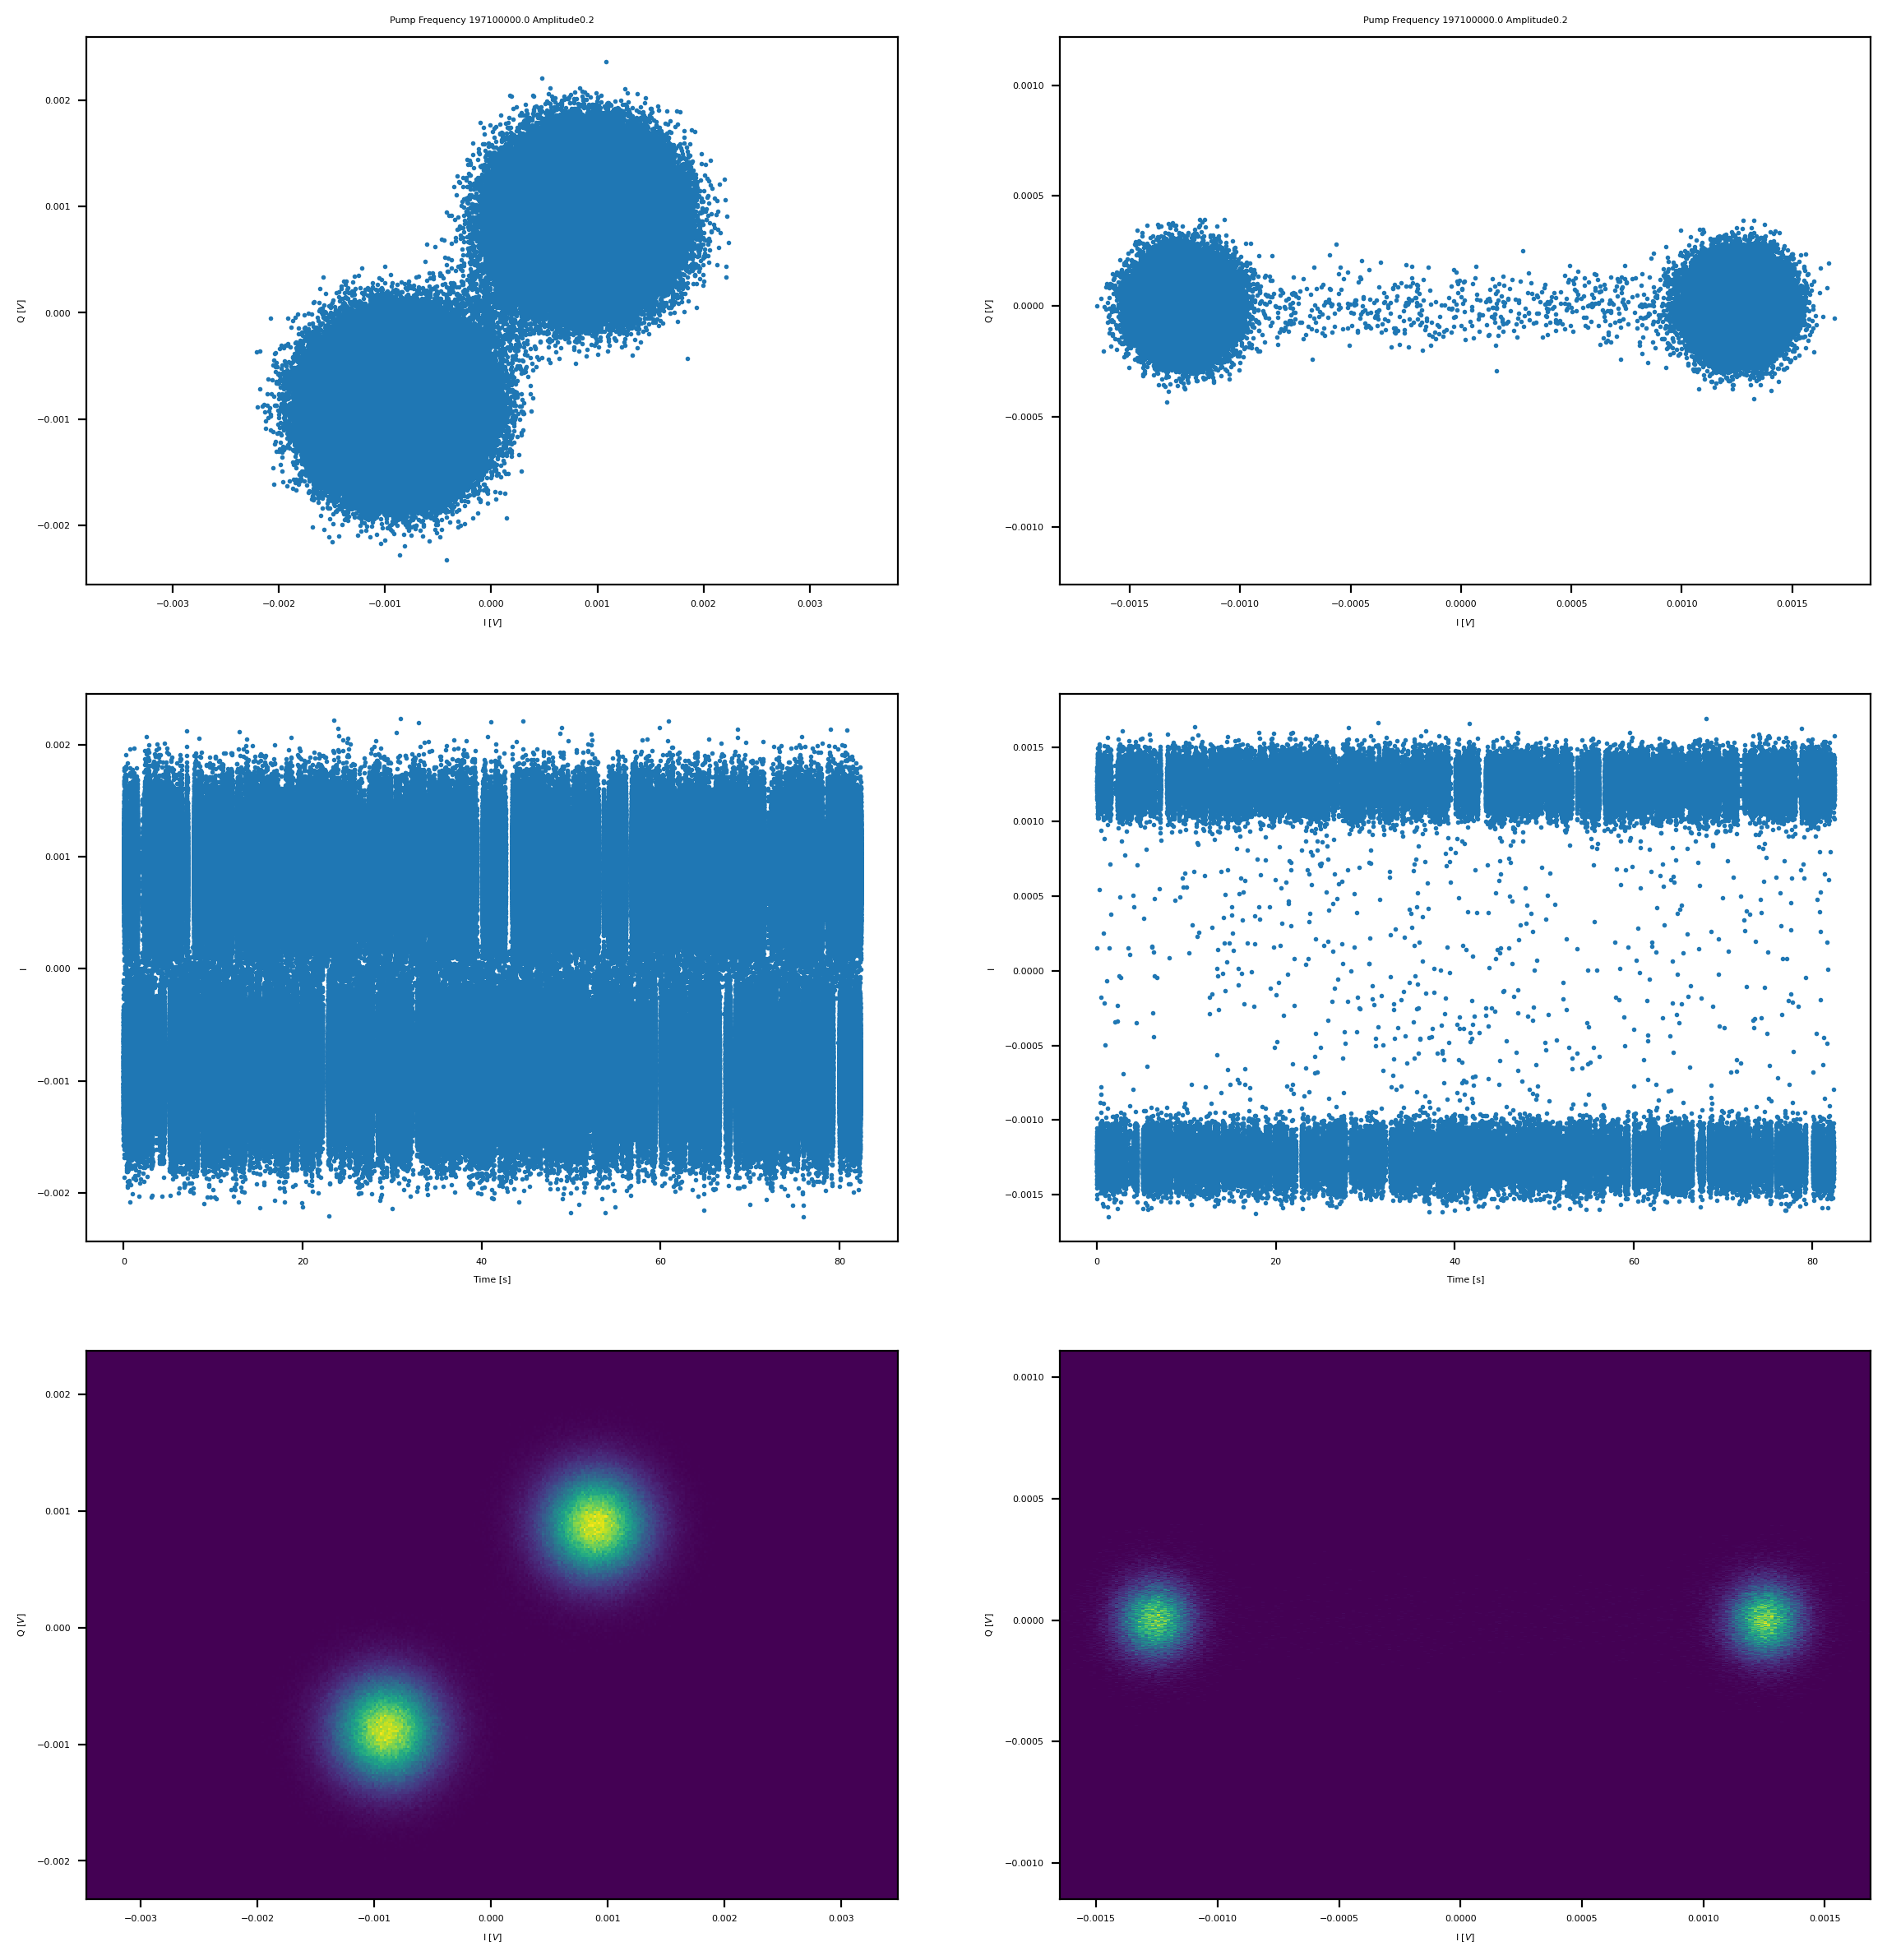

In [135]:
#Plotting with and without the noise reduction 

%matplotlib inline

bin_size=250 #bin size for the histogram 
figsize=(14,15)
fontsize=4
nb_angle=100 #number of angles for the rotation 
n_avg=10 #number of average

time=np.linspace(1,len(I), len(I),len(I))*dt # time in micro seconds

fig, axs = plt.subplots( nrows=3, ncols=2, figsize=figsize,dpi=200)

#Plot without reducing 
ax=axs[0,0]
ax.plot(I,Q,".",markersize=2)
ax.set_title('Pump Frequency '+str(IF_pump)+" Amplitude"+str(amp_factor),fontsize=fontsize)
ax.set_xlabel("I [$V$]",fontsize=fontsize)
ax.set_ylabel("Q [$V$]",fontsize=fontsize)
ax.tick_params(axis='x', labelsize=fontsize)
ax.tick_params(axis='y', labelsize=fontsize)
ax.axis("equal")

ax=axs[1,0]
ax.plot(time,I, ".", markersize=2)
ax.set_xlabel("Time [s]",fontsize=fontsize)
ax.set_ylabel("I",fontsize=fontsize)
ax.tick_params(axis='x', labelsize=fontsize)
ax.tick_params(axis='y', labelsize=fontsize)

ax=axs[2,0]
ax.hist2d(I,Q,bins=bin_size)
ax.set_xlabel("I [$V$]",fontsize=fontsize)
ax.set_ylabel("Q [$V$]",fontsize=fontsize)
ax.set_facecolor(color=(68/255,1/255,84/255))
ax.tick_params(axis='x', labelsize=fontsize)
ax.tick_params(axis='y', labelsize=fontsize)
ax.axis("equal")

#Plot with reducing 

#rotated data
I_2d=np.reshape(I, (1, I.shape[0])) 
Q_2d=np.reshape(Q, (1, Q.shape[0]))
rot_I,rot_Q=an.rotate_data(I_2d,Q_2d,nb_angle)
average_I,average_Q,time_average=an.average_data(rot_I,rot_Q,time,n_avg)


ax=axs[0,1]
ax.plot(average_I.transpose(),average_Q.transpose(),".",markersize=2)
ax.set_title('Pump Frequency '+str(IF_pump)+" Amplitude"+str(amp_factor),fontsize=fontsize)
ax.set_xlabel("I [$V$]",fontsize=fontsize)
ax.set_ylabel("Q [$V$]",fontsize=fontsize)
ax.tick_params(axis='x', labelsize=fontsize)
ax.tick_params(axis='y', labelsize=fontsize)
ax.axis("equal")


ax=axs[1,1]
ax.plot(time_average,average_I[0,:], ".", markersize=2)
ax.set_xlabel("Time [s]",fontsize=fontsize)
ax.set_ylabel("I",fontsize=fontsize)
ax.tick_params(axis='x', labelsize=fontsize)
ax.tick_params(axis='y', labelsize=fontsize)


ax=axs[2,1]
ax.hist2d(average_I[0,:],average_Q[0,:],bins=bin_size)
ax.set_xlabel("I [$V$]",fontsize=fontsize)
ax.set_ylabel("Q [$V$]",fontsize=fontsize)
ax.set_facecolor(color=(68/255,1/255,84/255))
ax.tick_params(axis='x', labelsize=fontsize)
ax.tick_params(axis='y', labelsize=fontsize)
ax.axis("equal")

print("Average signal : {}".format(np.mean(abs(I))))


In [138]:
#Finding the jumps 
%matplotlib inline 

figsize=(6,5)
fontsize=8
length_array=average_I.shape[1] 

#renormalize the data and find jumps 
av = np.mean(abs(average_I))
jumps=an.find_jumps(average_I[0]/av,length_array)

#Plot I vs time and the identified jumps  jumps 
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=figsize,dpi=100)
ax=axs
ax.plot(time_average, average_I[0])
for j in jumps:
    ax.axvline(time_average[int(j)], c='r', lw=1, ls='--')
    
ax.set_xlabel("Time [s]",fontsize=fontsize)
ax.set_ylabel("I",fontsize=fontsize)
ax.tick_params(axis='x', labelsize=fontsize)
ax.tick_params(axis='y', labelsize=fontsize)
ax.set_title("Number of jumps: " +str(len(jumps)))

KeyboardInterrupt: 

In [47]:
#Potential update of the parameters 

nb_desired_jumps=100
nb_points_between_jumps=1000

time_per_jump=time_average[length_array-1]/len(jumps)
Total_time= time_per_jump*nb_desired_jumps #total time I should measure to get 100 jumps 

length_of_readout=round(time_per_jump*1e9/nb_points_between_jumps) # readout len
length_of_readout=4*round(length_of_readout/4)

if length_of_readout>2_000_000:
    length_of_readout=2_000_000


Nb_points=round(Total_time*1e9/length_of_readout)

print("Length of readout {}".format(length_of_readout))
print("Number of points  {}".format(Nb_points))
print("Total time  {}".format(Total_time/60))

#Update the readout length based on the single test
Readout_Len= length_of_readout    
config,qm=update_readout_lenght(Readout_Len,config,qmm)

#Pump length 
two_Photon_len=Readout_Len
config,qm=update_two_photon_lenght(twoPhoton_len,config,qmm)

n_runs=Nb_points


Length of readout 837760
Number of points  100000
Total time  1.3962704983333334


In [127]:
#Saving the data
cooldown_date="2023_03_17"
meastype="single_IQ_trace" #Final file name 
name="Run01"
device="123"

datadict={}
datadict["LO_fluxline"]=LO_fluxline
datadict["IF_fluxline"]=IF_pump
datadict=["IF_readout"]=IF_resonator
datadict=["LO_readout"]=LO_readout


datadict["n_runs"]=n_runs
datadict["amp_factor"]=amp_factor
datadict["Offset_IF"]=Offset_IF
datadict["Readout_Len"]=Readout_Len
datadict["Readout_Delay"]=Readout_Delay
datadict["I"]=I
datadict["Q"]=Q
datadict["tau"]=tau


In [128]:
an.save_data(datadict, meastype, name, device, cooldown_date, bias=0, filepath=r"C:\Users\hqclabo\Documents\Data\gbeaulieu\Two_Photon\\")

Data saved


# Updating program of IQ blobs

## Single run - Find parameters

In [75]:
#Program single run 
%matplotlib qt

IF_pump=0.197e9#0.19735e9  # defines the IF of the pump 
IF_resonator=(LO_fluxline+IF_pump)/2-LO_readout #demodulate at half of the pump IF by default 
Readout_Delay = 50_000 //4 # Delay before the first readout in ns (convert from clockcycle)
Offset_IF=0
amp_factor=0.2

nb_desired_jumps=50
nb_points_between_jumps=1000
threshold=5e-4

init_nruns=200000
init_Readout_Len=50_000

I,Q,rot_I,rot_Q,time,counter,Readout_Len,n_runs,jumps,stop=Update_single_IQ_trace(config,IF_pump,IF_resonator,Offset_IF,amp_factor,qm,nb_desired_jumps,nb_points_between_jumps,nb_angle=100,n_avg=10,init_Readout_Len=init_Readout_Len,init_nruns=init_nruns,threshold=threshold )

########### Iteration number : 1 ##########
The program is initalized with :
A readout length of 50000
The Number of points  200000
Time for iteration  0.16666666666666666 min
2023-04-07 18:49:12,747 - qm - INFO - Flags: 
2023-04-07 18:49:12,748 - qm - INFO - Sending program to QOP
2023-04-07 18:49:13,213 - qm - INFO - Executing program
Out_of_qm
Execution stopped by user!
0.0013532900095805274
Jumps found 239
########### Iteration number : 2 ##########
New readout length of 50000
New number of points 42064
Time for iteration  0.03505360458158995 min
2023-04-07 18:50:10,797 - qm - INFO - Flags: 
2023-04-07 18:50:10,797 - qm - INFO - Sending program to QOP
2023-04-07 18:50:11,239 - qm - INFO - Executing program
Out_of_qm
Execution stopped by user!
0.0013436989839982168
Jumps found 60
Success


## Multiple runs - Find parameters 

In [ ]:
%%time
#The idea is that this program is used to get a first quick estimates. Therefore, it should be launched with a few numbers of nb_desired_jumps
# Moreover, we should use quite a high threshold, because anyway below the threshold, we will fix the readout_len to 50_000
%matplotlib qt 

span=1 * u.MHz # Span of the pumping 
df = 0.02* u.MHz # Step of the pumping 0.01
IF_center=0.1971e9
freqs = np.arange(IF_center-span/2, IF_center+span/2, df) #sets of frequencies

Readout_Delay = 5000 //4 # Delay before the first readout in ns (convert from clockcycle)
Offset_IF=0
amp_factor=0.23
nb_desired_jumps=30
nb_points_between_jumps=1000
threshold=5e-4

Data={} #dictionnary to hold all the data 

for idx,IF_pump in enumerate(freqs) :
    print("########################### Frequency "+str(IF_pump+LO_fluxline)+"########################### "+str(idx/len(freqs)))
    
    Data[IF_pump]={}
    
    IF_resonator=(LO_fluxline+IF_pump)/2-LO_readout #demodulate at half of the pump IF by default                                                    
    I,Q,rot_I,rot_Q,time,counter,Readout_Len,n_runs,jumps,vaccum=Update_single_IQ_trace(config,IF_pump,IF_resonator,Offset_IF,amp_factor,qm,nb_desired_jumps,nb_points_between_jumps,nb_angle=100,n_avg=10,init_Readout_Len=50_000,init_nruns=200000,threshold=threshold )
    
    #Saving the data
    Data[IF_pump]["I"]=I
    Data[IF_pump]["Q"]=Q
    Data[IF_pump]["rot_I"]=rot_I
    Data[IF_pump]["rot_Q"]=rot_Q
    Data[IF_pump]["jumps"]=jumps
    Data[IF_pump]["counter"]=counter
    Data[IF_pump]["Readout_Len"]=Readout_Len
    Data[IF_pump]["n_runs"]=n_runs
    Data[IF_pump]["time"]=time
    Data[IF_pump]["vaccum"]=vaccum

########################### Frequency 8696600000.0########################### 0.0
2023-04-07 21:25:12,453 - qm - WARNING - Open QM ended with warning 0: Opening a new Quantum Machine and closing Quantum Machines: 
2023-04-07 21:25:12,454 - qm - WARNING - Open QM ended with warning 0: Quantum Machine qm-1680895451997 is canceling running job 1680525784750.
########### Iteration number : 1 ##########
The program is initalized with :
A readout length of 50000
The Number of points  200000
Time for iteration  0.16666666666666666 min
2023-04-07 21:25:13,512 - qm - INFO - Flags: 
2023-04-07 21:25:13,512 - qm - INFO - Sending program to QOP
2023-04-07 21:25:14,689 - qm - INFO - Executing program
Out_of_qm
Execution stopped by user!
7.257210340009423e-05
vaccum state
########################### Frequency 8696620000.0########################### 0.02
########### Iteration number : 1 ##########
The program is initalized with :
A readout length of 50000
The Number of points  200000
Time for iterati

### Analyzing multiple runs 

In [8]:
# I think the idea will be to do that for like 50 jumps and then readapte everything to have better results 
# So to readapte, we want to plot everything 
%matplotlib qt
idx=4
bin_size=100
fontsize=5
figsize=(4,12)
FileName="Test"
movie=True

def create_frame(idx,Data,FileName,bin_size,fontsize,movie=False):

    rot_I=Data[freqs[idx]]["rot_I"][0,:]
    rot_Q=Data[freqs[idx]]["rot_Q"][0,:]
    time=Data[freqs[idx]]["time"]
    Readout_Len=Data[freqs[idx]]['Readout_Len']
    n_runs=Data[freqs[idx]]['n_runs']
    jumps=Data[freqs[idx]]["jumps"]
    vaccum=Data[freqs[idx]]["vaccum"]

    fig= plt.figure(figsize=figsize,dpi=300)

    ax = plt.subplot(311)
    ax.plot(rot_I,rot_Q,".",markersize=2)
    ax.set_title('Pump Frequency '+str(freqs[idx])+ "GHz"+" Frame: "+str(idx),fontsize=fontsize)
    ax.set_xlabel("I [$\mu V$]",fontsize=fontsize)
    ax.set_ylabel("Q [$\mu V$]",fontsize=fontsize)
    ax.tick_params(axis='x', labelsize=fontsize)
    ax.tick_params(axis='y', labelsize=fontsize)


    ax=plt.subplot(312)
    ax.set_title('Number of runs:'+str(n_runs)+ " Readout_Len :"+str(Readout_Len),fontsize=fontsize)
    plt.plot(time,rot_I, ".", markersize=2)
    plt.xlabel("Time [s]",fontsize=fontsize)
    plt.ylabel("Phase",fontsize=fontsize)
    ax.tick_params(axis='x', labelsize=fontsize)
    ax.tick_params(axis='y', labelsize=fontsize)


    ax = plt.subplot(313)
    ax.set_title('Number of jumps:'+str(len(jumps))+" Vaccum = "+str(vaccum),fontsize=fontsize)
    ax.hist2d(rot_I,rot_Q,bins=bin_size)
    ax.set_xlabel("I [$\mu V$]",fontsize=fontsize)
    ax.set_ylabel("Q [$\mu V$]",fontsize=fontsize)
    ax.tick_params(axis='x', labelsize=fontsize)
    ax.tick_params(axis='y', labelsize=fontsize)
    ax.set_ylim(-0.0025, 0.0025) 
    ax.set_xlim(-0.0025, 0.0025)
    ax.set_facecolor(color=(68/255,1/255,84/255))
    
    if movie:
        plt.savefig(f'./'+FileName+f'/img_{idx}.png', 
                        transparent = False,  
                        facecolor = 'white'
                       )    
        plt.close()
    

if movie==True :
    for idx in range(len(Data)):
        create_frame(idx,Data,FileName,bin_size,fontsize,movie=True)
else:
    create_frame(idx,Data,FileName,bin_size,fontsize,movie=movie)
    


In [9]:
cooldown_date="2023_03_31" #top folder 
device="Run01" #second folder 
name="104_parameter_IQ" # third folder 
meastype="0p2_amp" #Final file name 


datadict={}
datadict["freqs"]=freqs
datadict["Readout_Delay"]=Readout_Delay
datadict["Offset_IF"]=Offset_IF
datadict["amp_factor"]=amp_factor
datadict["nb_desired_jumps"]=nb_desired_jumps
datadict["nb_points_between_jumps"]=nb_points_between_jumps 
for i in range(len(freqs)):
    datadict["Data"+str(i)]=Data[freqs[i]]
datadict["configuration"]=config

an.save_data(datadict, meastype, name, device, cooldown_date, bias=0, filepath=r"C:\Users\hqclabo\Documents\Data\gbeaulieu\Two_Photon\\")

Data saved


### Extract the Parameters

In [10]:
data_dir=scipy.io.loadmat(r"C:\Users\HQClabo\Documents\Data\gbeaulieu\Two_Photon\2023_03_31\Run01\104_parameter_IQ\0p23_amp.mat", mdict=None, appendmat=True)

In [13]:
50_000*200_000*1e-9/60

0.16666666666666666

In [15]:
# Based on the previous collected information, we now want to select the readout length and time 

minim_n_runs=200_000
minim_Read_out=50_000
desired_jumps=100

Parameters={}
Total_time_vec=[]

Parameters["Readout_Delay"]=data_dir["Readout_Delay"][0][0]
Parameters["Offset_IF"]=data_dir["Offset_IF"][0][0]
Parameters["amp_factor"]=data_dir["amp_factor"][0][0]
Parameters["freqs"]=data_dir["freqs"][0]

freqs=data_dir["freqs"][0]
n_Data={}
#Rebuild the Data dictionnary :
for i in range(len(freqs)):
    IF_pump=freqs[i]
    n_Data[IF_pump]={}
    n_Data[IF_pump]["Q"]=data_dir["Data"+str(i)]["I"][0][0][0]
    n_Data[IF_pump]["Q"]=data_dir["Data"+str(i)]["Q"][0][0][0]
    n_Data[IF_pump]["rot_I"]=data_dir["Data"+str(i)]["rot_I"][0][0][0]
    n_Data[IF_pump]["rot_Q"]=data_dir["Data"+str(i)]["rot_Q"][0][0][0]
    n_Data[IF_pump]["counter"]=data_dir["Data"+str(i)]["counter"][0][0][0][0]
    n_Data[IF_pump]["Readout_Len"]=data_dir["Data"+str(i)]["Readout_Len"][0][0][0][0]
    n_Data[IF_pump]["n_runs"]=data_dir["Data"+str(i)]["n_runs"][0][0][0][0]
    n_Data[IF_pump]["time"]=data_dir["Data"+str(i)]["time"][0][0][0]
    n_Data[IF_pump]["vaccum"]=data_dir["Data"+str(i)]["vaccum"][0][0][0][0]
    if n_Data[IF_pump]["vaccum"]:
        n_Data[IF_pump]["jumps"]=[]
    else:
        n_Data[IF_pump]["jumps"]=data_dir["Data"+str(3)]["jumps"][0][0][0]

        
        
for i in range(len(n_Data)):
    
    IF_pump=freqs[i]
    Parameters[IF_pump]={} # For each frequency 
    
    Readout_Len=n_Data[IF_pump]["Readout_Len"]
    n_runs=n_Data[IF_pump]["n_runs"]
    vaccum=n_Data[IF_pump]["vaccum"]
    jumps=n_Data[IF_pump]["jumps"]
   
    #If we are in the vaccum case, we assign the minimum parameters 
    if vaccum:
        Parameters[IF_pump]["n_runs"]=minim_n_runs # For each frequency 
        Parameters[IF_pump]["Readout_Len"]=minim_Read_out
        Total_time=minim_n_runs*minim_Read_out*1e-9
        Total_time_vec.append(Total_time)
        Parameters[IF_pump]["Total_time"]=np.around(Total_time/60, decimals=2)
        
    else :
        update_n_runs=round(n_runs/len(jumps)*desired_jumps)
        Parameters[IF_pump]["n_runs"]=int(update_n_runs)
        Parameters[IF_pump]["Readout_Len"]=int(Readout_Len)
        Total_time=int(Readout_Len)*int(update_n_runs)*1e-9 # total time in seconds
        Total_time_vec.append(Total_time)
        
        Parameters[IF_pump]["Total_time"]=np.around(Total_time/60, decimals=2)


print("The estimated time for the measurement is {} min".format(sum(Total_time_vec)/60))
Parameters

The estimated time for the measurement is 18.776305451 min


{'Readout_Delay': 1250,
 'Offset_IF': 0,
 'amp_factor': 0.23,
 'freqs': array([1.966e+08, 1.967e+08, 1.968e+08, 1.969e+08, 1.970e+08, 1.971e+08,
        1.972e+08, 1.973e+08, 1.974e+08, 1.975e+08]),
 196600000.0: {'n_runs': 200000, 'Readout_Len': 50000, 'Total_time': 0.17},
 196700000.0: {'n_runs': 200000, 'Readout_Len': 50000, 'Total_time': 0.17},
 196800000.0: {'n_runs': 200000, 'Readout_Len': 50000, 'Total_time': 0.17},
 196900000.0: {'n_runs': 80645, 'Readout_Len': 1005336, 'Total_time': 1.35},
 197000000.0: {'n_runs': 80645, 'Readout_Len': 1709920, 'Total_time': 2.3},
 197100000.0: {'n_runs': 405377, 'Readout_Len': 2000000, 'Total_time': 13.51},
 197200000.0: {'n_runs': 80645, 'Readout_Len': 456972, 'Total_time': 0.61},
 197300000.0: {'n_runs': 200000, 'Readout_Len': 50000, 'Total_time': 0.17},
 197400000.0: {'n_runs': 200000, 'Readout_Len': 50000, 'Total_time': 0.17},
 197500000.0: {'n_runs': 200000, 'Readout_Len': 50000, 'Total_time': 0.17}}

## Run full measurement

In [16]:
%%time
%matplotlib qt

freqs=Parameters["freqs"]
Readout_Delay =int(Parameters["Readout_Delay"])
Offset_IF=int(Parameters["Offset_IF"])
amp_factor=Parameters["amp_factor"]

for idx in range(len(freqs)):



    IF_pump=float(freqs[idx])
    IF_resonator=(LO_fluxline+IF_pump)/2-LO_readout

    Readout_Len=int(Parameters[IF_pump]["Readout_Len"])
    n_runs=int(Parameters[IF_pump]["n_runs"])

    config,qm=update_readout_lenght(Readout_Len,config,qmm)
    twoPhoton_len=Readout_Len
    config,qm=update_two_photon_lenght(twoPhoton_len,config,qmm)

    print(IF_pump)
    print(IF_resonator)
    print(n_runs)
    print(Readout_Delay)
    print(Readout_Len)
    print(amp_factor)
    I,Q,time=single_IQ_trace(IF_pump,IF_resonator,Offset_IF,amp_factor,n_runs,Readout_Delay,Readout_Len,qm)
    time_package.sleep(1)
    plt.close()

196600000.0
348300000.0
200000
1250
50000
0.23
2023-04-07 21:22:33,721 - qm - INFO - Flags: 
2023-04-07 21:22:33,722 - qm - INFO - Sending program to QOP
2023-04-07 21:22:34,180 - qm - INFO - Executing program
Execution stopped by user!
196700000.0
348350000.0
200000
1250
50000
0.23
2023-04-07 21:22:46,295 - qm - INFO - Flags: 
2023-04-07 21:22:46,296 - qm - INFO - Sending program to QOP
2023-04-07 21:22:47,120 - qm - INFO - Executing program
Execution stopped by user!
196800000.0
348400000.0
200000
1250
50000
0.23
2023-04-07 21:22:59,075 - qm - INFO - Flags: 
2023-04-07 21:22:59,076 - qm - INFO - Sending program to QOP
2023-04-07 21:22:59,536 - qm - INFO - Executing program
Execution stopped by user!
196900000.0
348450000.0
80645
1250
1005336
0.23
2023-04-07 21:23:11,609 - qm - INFO - Flags: 
2023-04-07 21:23:11,610 - qm - INFO - Sending program to QOP
2023-04-07 21:23:19,877 - qm - INFO - Executing program
Execution stopped by user!
197000000.0
348500000.0
80645
1250
1709920
0.23
202

KeyboardInterrupt: 

## IQ blob frequencies sweep 

Runs the IQ blob program for multiple frequencies (flux line and demodulation frequency are swept) while the amplitude factor of the puls remains cst. The pump pulse should probably be around the readout len to avoid useless extra time 

Need to make sure that the new updated IF frequency doesn't go over 350 MHz.

Note : the maximum number of variables that can be steamed is 100e6. if there is a timestamp attached to it, it will be doubled

In [49]:
#Program variable definition 

Readout_Len=50_000#length of the readout pulse in ns 

span=1.1 * u.MHz # Span of the pumping 
df = 0.01 * u.MHz # Step of the pumping 0.01
IF_center=0.3004e9   #0.2357e9  #0.2367e9 #fluxline if frequency center 
freqs = np.arange(IF_center-span/2, IF_center+span/2, df) #sets of frequencies

n_runs = 50000*5 #Number of readout to do 

Readout_Delay=50000//4 # Delay before making the first readout 
cooldown_time_pump = 16000 // 4 # Time delay between applying sucessive pumps upgrading the frequency 

amp_factor=0.4 #Prefactor of the amplitude 

Offset_IF=0  #-5670.0 +400 #+1000 #+10000

LO_diff=LO_fluxline/2-LO_readout # need to perform this substraction outside of the qua program to avoid having numbers larger than the int allowed 


#Saving path 
cooldown_date="2023_03_17"
meastype="amp_0p4_longer_pio6" #Final file name 
name="Run01"
device="104"
datadict={}




NumberPoints=n_runs*freqs.shape[0]
print("The Numbber of points is : {}".format(NumberPoints))
print("The fraction from maximum buffer capability is : {}".format(NumberPoints*2/100e6))
print("The estimated time per trace is {} minutes".format((n_runs*(Readout_Len*1e-9))/60))
print("The total estimated time {} minutes".format((NumberPoints*(Readout_Len*1e-9))/60))

The Numbber of points is : 27500000
The fraction from maximum buffer capability is : 0.55
The estimated time per trace is 0.20833333333333334 minutes
The total estimated time 22.916666666666668 minutes


In [50]:
%%time

%matplotlib qt
from scipy import signal


#config["pulses"]["twoPhoton"]["length"]=5000 #Length of the pumping pulse
config["pulses"]["zero_pulse"]["length"]=Readout_Len
config["integration_weights"]["cosine_weights"]["cosine"][0]=(1.0, Readout_Len)
config["integration_weights"]["cosine_weights"]["sine"][0]=(0.0, Readout_Len)
config["integration_weights"]["sine_weights"]["cosine"][0]=(0.0, Readout_Len)
config["integration_weights"]["sine_weights"]["sine"][0]=(1.0, Readout_Len)
config["integration_weights"]["minus_sine_weights"]["cosine"][0]=(0.0, Readout_Len)
config["integration_weights"]["minus_sine_weights"]["sine"][0]=(-1.0, Readout_Len)

#Update the config with the modified values above 
qm = qmm.open_qm(config)



# Set of pump frequencies 


with program() as IQ_blobs:
    
    n = declare(int)
    i = declare(int)
    I = declare(fixed)
    Q = declare(fixed)
    assign_variables_to_element("resonator", I,Q) #This line forces the OPX to assign I and Q to the resonator element such that the loops can happen in parallel as intented
    I_st = declare_stream() # Data paths
    Q_st = declare_stream() # Data paths
    
    
    f = declare(int)
    f_readout = declare(int)
   

    with for_(*from_array(f,freqs)):  # Notice it's < a_max + da/2 to include a_max
        
        assign(f_readout,LO_diff+f/2+Offset_IF) #update the readout frequency 
        update_frequency("resonator",f_readout) # Change the IF frequency of the resonator to demodulate more precisely 
        update_frequency("fluxline",f) # updates the IF frequency to the array 
        
    
        with for_(i, 0, i < np.round((n_runs*(Readout_Len+300)+Readout_Delay*4)/twoPhoton_len)+1, i + 1): # the 300 is added because there is a time delay associated to saving the data in the steam. The *4 is necessary because the waiting time is in clockcycle 
            play("pumping" * amp(amp_factor), 'fluxline')  # Play the pulse on the fluxline
            
        #Delay time before the first readout 
        wait(Readout_Delay,"resonator")
        
        with for_(n, 0, n < n_runs, n + 1):

            #reset_phase("resonator")

            #Demodulate for the length 
            measure(
                "fake_readout",
                "resonator",
                None,
                dual_demod.full("cos", "out1", "sin", "out2", I),
                dual_demod.full("minus_sin", "out1", "cos", "out2", Q),
            )

            save(I, I_st) # Save data to path
            save(Q, Q_st) # Save data to path 

            #Waiting time before the next readout 
            #wait(cooldown_time_resonator,"resonator")
            
        #waiting time before the next pump     
        wait(cooldown_time_pump)
        

    with stream_processing():
        I_st.with_timestamps().save_all("I") #save in an array of len(freqs) rows and n_runs column 
        Q_st.with_timestamps().save_all("Q")
        

        
simulation = False 

if simulation: 
    simulation_config = SimulationConfig(
        duration=70000, simulation_interface=LoopbackInterface([("con1", 3, "con1", 1)])
    )
    
    job = qmm.simulate(config, IQ_blobs, simulation_config)
    job.get_simulated_samples().con1.plot(analog_ports={'1','2','3','4' },digital_ports={'1','3'})

    
    
else:
  

  
    job = qm.execute(IQ_blobs)
    results = fetching_tool(job, data_list=["I", "Q"], mode="live")
    
    # Live plotting
    fig = plt.figure()
    interrupt_on_close(fig, job)  #  Interrupts the job when closing the figure
    
    while results.is_processing():
        I, Q = results.fetch_all()
        
        dt=(I["timestamp"][1]-I["timestamp"][0])*1e-9 #time between sucessive points
        
        
        
        I = u.demod2volts(I["value"], pulse_len) #diviser par la duree du pulse 
        Q = u.demod2volts(Q["value"], pulse_len)

        #plt.subplot(211)
        
        plt.title("IQ blobs")
        plt.subplot(211)
        plt.cla()
        plt.plot(I[:min(len(I), len(Q))], Q[:min(len(I), len(Q))], ".", markersize=2)
        plt.xlabel("I")
        plt.ylabel("Q")
        plt.axis("equal")
        plt.subplot(212)
        plt.cla()
        tau=np.linspace(1,min(len(I), len(Q)),min(len(I), len(Q)))
        plt.plot(np.angle(I[:min(len(I), len(Q))]+1j*Q[:min(len(I), len(Q))]), ".", markersize=2)
        plt.xlabel("Nb points")
        plt.ylabel("phase")
        plt.pause(0.1)
        #plt.axis("equal")
        #job.halt()
        
        
        
#Saving 
datadict["LO_fluxline"]=LO_fluxline
datadict["IF_fluxline"]=IF_fluxline
datadict["IF_readout"]=IF_readout
datadict["LO_readout"]=LO_readout
datadict["freqs"]=freqs

datadict["n_runs"]=n_runs
datadict["amp_factor"]=amp_factor
datadict["Offset_IF"]=Offset_IF
datadict["Readout_Len"]=Readout_Len
datadict["Readout_Delay"]=Readout_Delay
datadict["I"]=I.reshape((freqs.shape[0],n_runs))
datadict["Q"]=Q.reshape((freqs.shape[0],n_runs))
datadict["tau"]=tau

an.save_data(datadict, meastype, name, device, cooldown_date, bias=0, filepath=r"C:\Users\hqclabo\Documents\Data\gbeaulieu\Two_Photon\\")

2023-03-24 17:10:40,920 - qm - INFO - Flags: 
2023-03-24 17:10:40,921 - qm - INFO - Sending program to QOP
2023-03-24 17:10:41,857 - qm - INFO - Executing program
Data saved
Wall time: 23min 44s
Execution stopped by user!


In [52]:
#Plotting of the different data sets taken 
I_r=I.reshape((freqs.shape[0],n_runs))
Q_r=Q.reshape((freqs.shape[0],n_runs))

plt.close("all") # close all open figures 
for i in range(freqs.shape[0]):
    fig = plt.figure()
    plt.subplot(211)
    plt.plot(I_r[i,:], Q_r[i,:], ".", markersize=2)
    plt.xlabel("I (V)")
    plt.ylabel("Q (V)")
    plt.axis("equal")
    plt.title("Pump Frequency : " +str((LO_fluxline+freqs[i])/1e9)+" GHz")
    plt.subplot(212)
    tau=np.linspace(1,len(I_r[i,:]), len(I_r[i,:]),len(I_r[i,:]))*dt*10e6 # time in micro seconds
    plt.plot(np.angle(I_r[i,:]+1j*Q_r[i,:]), ".", markersize=2)
    plt.xlabel("Time (us)")
    plt.ylabel("Phase")
    
    

In [53]:
plt.close("all") # close all open figures 

## IQ blob Amplitudes sweep 

For a fixed pump frequency and demodulation frequency, the amplitude is swept

In [38]:
#Program variable definition 

Readout_Len=5_000#length of the readout pulse in ns 

#Amplitude sweep
a_min = 0.0
a_max = 0.5
da = 0.05
amplitudes = np.arange(a_min, a_max + da / 2, da)  # +da/2 to add a_max to the scan (vector of amplitudes)


#Update the pump IF frequency 
IF_pump=0.26e9 # defines the IF of the pump 
IF_resonator=(LO_fluxline+IF_pump)/2-LO_readout #demodulate at half of the pump IF by default 

n_runs = 1000 #Number of readout to do 

Readout_Delay=50000//4 # Delay before making the first readout 
cooldown_time_pump = 100000 // 4 # Time delay between applying sucessive pumps upgrading the frequency 

amp_factor=0.3 #Prefactor of the amplitude 

Offset_IF=0  #-5670.0 +400 #+1000 #+10000


#Saving path 
cooldown_date="2023_03_17"
meastype="Program_Tests" #Final file name 
name="Run01"
device="123"
datadict={}




NumberPoints=n_runs*amplitudes.shape[0]
print("The Numbber of points is : {}".format(NumberPoints))
print("The fraction from maximum buffer capability is : {}".format(NumberPoints*2/100e6))
print("The estimated time per trace is {} minutes".format((n_runs*(Readout_Len*1e-9))/60))
print("The total estimated time {} minutes".format((NumberPoints*(Readout_Len*1e-9))/60))

The Numbber of points is : 11000
The fraction from maximum buffer capability is : 0.00022
The estimated time per trace is 8.333333333333333e-05 minutes
The total estimated time 0.0009166666666666668 minutes


In [39]:
%%time

%matplotlib qt
from scipy import signal


#config["pulses"]["twoPhoton"]["length"]=5000 #Length of the pumping pulse
config["pulses"]["zero_pulse"]["length"]=Readout_Len
config["integration_weights"]["cosine_weights"]["cosine"][0]=(1.0, Readout_Len)
config["integration_weights"]["cosine_weights"]["sine"][0]=(0.0, Readout_Len)
config["integration_weights"]["sine_weights"]["cosine"][0]=(0.0, Readout_Len)
config["integration_weights"]["sine_weights"]["sine"][0]=(1.0, Readout_Len)
config["integration_weights"]["minus_sine_weights"]["cosine"][0]=(0.0, Readout_Len)
config["integration_weights"]["minus_sine_weights"]["sine"][0]=(-1.0, Readout_Len)

#Update the config with the modified values above 
qm = qmm.open_qm(config)



# Set of pump frequencies 


with program() as IQ_blobs:
    
    n = declare(int)
    i = declare(int)
    I = declare(fixed)
    Q = declare(fixed)
    assign_variables_to_element("resonator", I,Q) #This line forces the OPX to assign I and Q to the resonator element such that the loops can happen in parallel as intented
    I_st = declare_stream() # Data paths
    Q_st = declare_stream() # Data paths
    a = declare(fixed)
   

    #loop on the amplitude 
    with for_(a, a_min, a < a_max + da / 2, a + da):  # Notice it's < a_max + da/2 to include a_max
        
        #Sets the frequencies 
        update_frequency("resonator",IF_resonator+Offset_IF) # Change the IF frequency of the resonator to demodulate more precisely 
        update_frequency("fluxline",IF_pump)
        
    
        with for_(i, 0, i < np.round((n_runs*(Readout_Len+300)+Readout_Delay*4)/twoPhoton_len)+1, i + 1): # the 300 is added because there is a time delay associated to saving the data in the steam. The *4 is necessary because the waiting time is in clockcycle 
            play("pumping" * amp(a), 'fluxline')  # Play the pulse on the fluxline
            
        #Delay time before the first readout 
        wait(Readout_Delay,"resonator")
        
        with for_(n, 0, n < n_runs, n + 1):

            #reset_phase("resonator")

            #Demodulate for the length 
            measure(
                "fake_readout",
                "resonator",
                None,
                dual_demod.full("cos", "out1", "sin", "out2", I),
                dual_demod.full("minus_sin", "out1", "cos", "out2", Q),
            )

            save(I, I_st) # Save data to path
            save(Q, Q_st) # Save data to path 

            #Waiting time before the next readout 
            #wait(cooldown_time_resonator,"resonator")
            
        #waiting time before the next pump     
        wait(cooldown_time_pump)
        

    with stream_processing():
        I_st.with_timestamps().save_all("I") #save in an array of len(freqs) rows and n_runs column 
        Q_st.with_timestamps().save_all("Q")
        

        
simulation = False

if simulation: 
    simulation_config = SimulationConfig(
        duration=70000, simulation_interface=LoopbackInterface([("con1", 3, "con1", 1)])
    )
    
    job = qmm.simulate(config, IQ_blobs, simulation_config)
    job.get_simulated_samples().con1.plot(analog_ports={'1','2','3','4' },digital_ports={'1','3'})

    
    
else:
  

  
    job = qm.execute(IQ_blobs)
    results = fetching_tool(job, data_list=["I", "Q"], mode="live")
    
    # Live plotting
    fig = plt.figure()
    interrupt_on_close(fig, job)  #  Interrupts the job when closing the figure
    
    while results.is_processing():
        I, Q = results.fetch_all()
        
        dt=(I["timestamp"][1]-I["timestamp"][0])*1e-9 #time between sucessive points
        
        
        
        I = u.demod2volts(I["value"], pulse_len) #diviser par la duree du pulse 
        Q = u.demod2volts(Q["value"], pulse_len)

        #plt.subplot(211)
        
        plt.title("IQ blobs")
        plt.subplot(211)
        plt.cla()
        plt.plot(I[:min(len(I), len(Q))], Q[:min(len(I), len(Q))], ".", markersize=2)
        plt.xlabel("I")
        plt.ylabel("Q")
        plt.axis("equal")
        plt.subplot(212)
        plt.cla()
        tau=np.linspace(1,min(len(I), len(Q)),min(len(I), len(Q)))
        plt.plot(np.unwrap(np.angle(I[:min(len(I), len(Q))]+1j*Q[:min(len(I), len(Q))])), ".", markersize=2)
        plt.xlabel("Nb points")
        plt.ylabel("phase")
        plt.pause(0.1)
        #plt.axis("equal")
        #job.halt()
        
        
        
#Saving 
datadict["LO_fluxline"]=LO_fluxline
datadict["IF_fluxline"]=IF_pump
datadict["IF_readout"]=IF_resonator
datadict["LO_readout"]=LO_readout

datadict["amplitudes"]=amplitudes

datadict["n_runs"]=n_runs
datadict["amp_factor"]=amp_factor
datadict["Offset_IF"]=Offset_IF
datadict["Readout_Len"]=Readout_Len
datadict["Readout_Delay"]=Readout_Delay
datadict["I"]=I.reshape((amplitudes.shape[0],n_runs))
datadict["Q"]=Q.reshape((amplitudes.shape[0],n_runs))
datadict["tau"]=tau

an.save_data(datadict, meastype, name, device, cooldown_date, bias=0, filepath=r"C:\Users\hqclabo\Documents\Data\gbeaulieu\Two_Photon\\")

2023-03-20 15:58:20,561 - qm - INFO - Flags: 
2023-03-20 15:58:20,562 - qm - INFO - Sending program to QOP
2023-03-20 15:58:21,044 - qm - INFO - Executing program
Wall time: 1.11 s


In [40]:
#Plotting of the different data sets taken 
I_r=I.reshape((amplitudes.shape[0],n_runs))
Q_r=Q.reshape((amplitudes.shape[0],n_runs))

plt.close("all") # close all open figures 
for i in range(amplitudes.shape[0]):
    fig = plt.figure()
    plt.subplot(211)
    plt.plot(I_r[i,:], Q_r[i,:], ".", markersize=2)
    plt.xlabel("I (V)")
    plt.ylabel("Q (V)")
    plt.axis("equal")
    plt.title("Pump amplitude factor : " +str(amplitudes[i]))
    plt.subplot(212)
    tau=np.linspace(1,len(I_r[i,:]), len(I_r[i,:]),len(I_r[i,:]))*dt*10e6 # time in micro seconds
    plt.plot(np.unwrap(np.angle(I_r[i,:]+1j*Q_r[i,:])), ".", markersize=2)
    plt.xlabel("Time (us)")
    plt.ylabel("Phase")

Execution stopped by user!


## IQ blob frequencies sweep frequencies Number_average_times

Sweeps the pump and demodulation frequency for a fixed amplitude and repeat this program n times 

In [56]:
#Program variable definition 

Readout_Len=500_000#length of the readout pulse in ns 

span=1.5 * u.MHz # Span of the pumping 
df = 0.1* u.MHz # Step of the pumping 0.01
IF_center=0.262e9 
freqs = np.arange(IF_center-span/2, IF_center+span/2, df) #sets of frequencies

n_runs = 1000 #Number of readout to do 

Readout_Delay=50000//4 # Delay before making the first readout 
cooldown_time_pump = 16000 // 4 # Time delay between applying sucessive pumps upgrading the frequency 

amp_factor=0.3 #Prefactor of the amplitude 

Offset_IF=0  #-5670.0 +400 #+1000 #+10000

LO_diff=LO_fluxline/2-LO_readout # need to perform this substraction outside of the qua program to avoid having numbers larger than the int allowed 

Number_Average=2

#Saving path 
cooldown_date="2023_03_17"
name="Run01"
device="123"
datadict={}





NumberPoints=n_runs*freqs.shape[0]
print("The Numbber of points is : {}".format(NumberPoints))
print("The fraction from maximum buffer capability is : {}".format(NumberPoints*2/100e6))
print("The estimated time per trace is {} minutes".format((n_runs*(Readout_Len*1e-9))/60))
print("The total estimated time {} minutes".format((NumberPoints*Number_Average*(Readout_Len*1e-9))/60))


#Saving 
datadict["LO_fluxline"]=LO_fluxline
datadict["IF_fluxline"]=IF_fluxline
datadict["IF_readout"]=IF_readout
datadict["LO_readout"]=LO_readout
datadict["freqs"]=freqs

datadict["n_runs"]=n_runs
datadict["amp_factor"]=amp_factor
datadict["Number_Average"]=Number_Average
datadict["Offset_IF"]=Offset_IF
datadict["Readout_Len"]=Readout_Len
datadict["Readout_Delay"]=Readout_Delay




  

The Numbber of points is : 15000
The fraction from maximum buffer capability is : 0.0003
The estimated time per trace is 0.008333333333333333 minutes
The total estimated time 0.25 minutes


In [60]:
%%time

%matplotlib qt
from scipy import signal


#config["pulses"]["twoPhoton"]["length"]=5000 #Length of the pumping pulse
config["pulses"]["zero_pulse"]["length"]=Readout_Len
config["integration_weights"]["cosine_weights"]["cosine"][0]=(1.0, Readout_Len)
config["integration_weights"]["cosine_weights"]["sine"][0]=(0.0, Readout_Len)
config["integration_weights"]["sine_weights"]["cosine"][0]=(0.0, Readout_Len)
config["integration_weights"]["sine_weights"]["sine"][0]=(1.0, Readout_Len)
config["integration_weights"]["minus_sine_weights"]["cosine"][0]=(0.0, Readout_Len)
config["integration_weights"]["minus_sine_weights"]["sine"][0]=(-1.0, Readout_Len)

#Update the config with the modified values above 
qm = qmm.open_qm(config)


# Set the matrix that will contain all the data
I_data=np.zeros((freqs.shape[0], n_runs, Number_Average))
Q_data=np.zeros((freqs.shape[0], n_runs, Number_Average))


with program() as IQ_blobs:
    
    n = declare(int)
    i = declare(int)
    I = declare(fixed)
    Q = declare(fixed)
    assign_variables_to_element("resonator", I,Q) #This line forces the OPX to assign I and Q to the resonator element such that the loops can happen in parallel as intented
    I_st = declare_stream() # Data paths
    Q_st = declare_stream() # Data paths
    
    
    f = declare(int)
    f_readout = declare(int)
   

    with for_(*from_array(f,freqs)):  # Notice it's < a_max + da/2 to include a_max
        
        assign(f_readout,LO_diff+f/2+Offset_IF) #update the readout frequency 
        update_frequency("resonator",f_readout) # Change the IF frequency of the resonator to demodulate more precisely 
        update_frequency("fluxline",f) # updates the IF frequency to the array 
        
    
        with for_(i, 0, i < np.round((n_runs*(Readout_Len+300)+Readout_Delay*4)/twoPhoton_len)+1, i + 1): # the 300 is added because there is a time delay associated to saving the data in the steam. The *4 is necessary because the waiting time is in clockcycle 
            play("pumping" * amp(amp_factor), 'fluxline')  # Play the pulse on the fluxline
            
        #Delay time before the first readout 
        wait(Readout_Delay,"resonator")
        
        with for_(n, 0, n < n_runs, n + 1):

            #reset_phase("resonator")

            #Demodulate for the length 
            measure(
                "fake_readout",
                "resonator",
                None,
                dual_demod.full("cos", "out1", "sin", "out2", I),
                dual_demod.full("minus_sin", "out1", "cos", "out2", Q),
            )

            save(I, I_st) # Save data to path
            save(Q, Q_st) # Save data to path 

            #Waiting time before the next readout 
            #wait(cooldown_time_resonator,"resonator")
            
        #waiting time before the next pump     
        wait(cooldown_time_pump)
        

    with stream_processing():
        I_st.with_timestamps().save_all("I") #save in an array of len(freqs) rows and n_runs column 
        Q_st.with_timestamps().save_all("Q")
        

        


for i in range(0,Number_Average,1) :  
    
    job = qm.execute(IQ_blobs)
    results = fetching_tool(job, data_list=["I", "Q"], mode="live")

    # Live plotting
    fig = plt.figure()
    interrupt_on_close(fig, job)  #  Interrupts the job when closing the figure

    while results.is_processing():
        I, Q = results.fetch_all()

        dt=(I["timestamp"][1]-I["timestamp"][0])*1e-9 #time between sucessive points



        I = u.demod2volts(I["value"], pulse_len) #diviser par la duree du pulse 
        Q = u.demod2volts(Q["value"], pulse_len)

        #plt.subplot(211)

        plt.suptitle("Iteration = "+str(i+1))
        plt.subplot(211)
        plt.cla()
        plt.plot(I[:min(len(I), len(Q))], Q[:min(len(I), len(Q))], ".", markersize=2)
        plt.xlabel("I")
        plt.ylabel("Q")
        plt.axis("equal")
        plt.subplot(212)
        plt.cla()
        tau=np.linspace(1,min(len(I), len(Q)),min(len(I), len(Q)))
        plt.plot(np.unwrap(np.angle(I[:min(len(I), len(Q))]+1j*Q[:min(len(I), len(Q))])), ".", markersize=2)
        plt.xlabel("Nb points")
        plt.ylabel("phase")
        plt.pause(0.1)
        #plt.axis("equal")
        #job.halt()
        
    I_data[:,:,i]=I.reshape((freqs.shape[0],n_runs))
    Q_data[:,:,i]=I.reshape((freqs.shape[0],n_runs))
    
    #Saving 
    meastype="Program_Tests"+ str(i) #Final file name 
    datadict["I_data"]=I_data[:,:,i]
    datadict["Q_data"]=Q_data[:,:,i]
    datadict["tau"]=tau
    
    an.save_data(datadict, meastype, name, device, cooldown_date, bias=0, filepath=r"C:\Users\hqclabo\Documents\Data\gbeaulieu\Two_Photon\\")


Execution stopped by user!
Execution stopped by user!
2023-03-20 16:32:16,874 - qm - INFO - Flags: 
2023-03-20 16:32:16,874 - qm - INFO - Sending program to QOP
2023-03-20 16:32:21,079 - qm - INFO - Executing program
Data saved
2023-03-20 16:32:29,277 - qm - INFO - Flags: 
2023-03-20 16:32:29,278 - qm - INFO - Sending program to QOP
2023-03-20 16:32:33,928 - qm - INFO - Executing program
Data saved
Wall time: 25 s


## IQ blob frequencies sweep frequencies N time for different amplitude

Sweeps the pump and demodulation frequency for a fixed amplitude and repeat this program n times 